# LSTM AE
Using a layer of LSTM in the decoder, we are able to learn longer sequences than before (for example here we are learning a sequence of length 30).

In [ ]:
import numpy as np
import pandas as pd
import torch 
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
length_seq = 30
n_sample = 800

train_data = []
samplerate = length_seq
for i in range(n_sample):
  fs1 = np.random.randint(samplerate)
  fs2 = np.random.randint(samplerate)
  t = np.linspace(0., 1., samplerate)
  amplitude1 = np.iinfo(np.int16).max/10000
  amplitude2 = np.iinfo(np.int16).max/20000
  data1 = amplitude1 * np.sin(2. * np.pi * fs1 * t)
  data2 = amplitude2 * np.sin(2. * np.pi * fs2 * t)
  train_data.append(data1+data2)

In [ ]:
train_data = np.array(train_data)
train_data = pd.DataFrame(train_data)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = pd.DataFrame(scaler.fit_transform(train_data))

In [ ]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_data_normalized)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim = 64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first = True,
      bidirectional = True
    )   
    self.rnn2 = nn.LSTM(
      input_size= 2 * self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True,
      bidirectional = True
    )
    self.l1 = nn.Linear(2 * self.embedding_dim, self.embedding_dim)

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    out = hidden_n.reshape((self.n_features, 2 * self.embedding_dim))
    return self.l1(out)

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim = 64, n_features = 1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1_layer1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn1_layer2 = nn.LSTM(
      input_size= input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2_layer2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn3_layer2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(3 * self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1_layer1(x)
    x1, (hidden_n, cell_n) = self.rnn1_layer2(x)
    x2, (hidden_n, cell_n) = self.rnn2_layer2(x)
    x3, (hidden_n, cell_n) = self.rnn3_layer2(x)
    x1 = x1.reshape((self.seq_len, self.hidden_dim))
    x2 = x2.reshape((self.seq_len, self.hidden_dim))
    x3 = x3.reshape((self.seq_len, self.hidden_dim))
    x = torch.cat((x1, x2, x3), 1)
    
    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 10)
model = model.to(device)

In [ ]:
seq_true = train_dataset[0]
seq_true = seq_true.to(device)
seq_pred = model(seq_true)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
import copy
model, history = train_model(
  model, 
  train_dataset, 
  train_dataset, 
  n_epochs = 50
)

Epoch 1: train loss 6.724267449229956 val loss 6.494776812046767
Epoch 2: train loss 6.4399580514431 val loss 6.409250004664063
Epoch 3: train loss 6.370921111404896 val loss 6.246801765933633
Epoch 4: train loss 6.2196788094937805 val loss 6.531630664542317
Epoch 5: train loss 6.202584043070674 val loss 6.119404499456286
Epoch 6: train loss 6.115149865448475 val loss 6.06137201949954
Epoch 7: train loss 6.008676980435848 val loss 5.968113323152065
Epoch 8: train loss 5.975325864255428 val loss 5.895581849813461
Epoch 9: train loss 5.940126416236162 val loss 5.962649250775575
Epoch 10: train loss 5.905192155614495 val loss 5.831590254753828
Epoch 11: train loss 5.843826935663819 val loss 5.787138670235873
Epoch 12: train loss 5.75208481259644 val loss 5.729607488140464
Epoch 13: train loss 5.738804613053799 val loss 5.640067381113767
Epoch 14: train loss 5.642627078294754 val loss 5.660716375857592
Epoch 15: train loss 5.6015058355778455 val loss 5.483116662427783
Epoch 16: train loss 

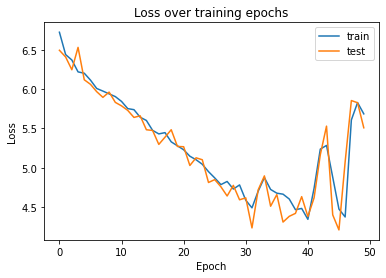

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
test_seq = train_dataset[10]
test_seq = test_seq.to(device)
seq_pred = model(test_seq)

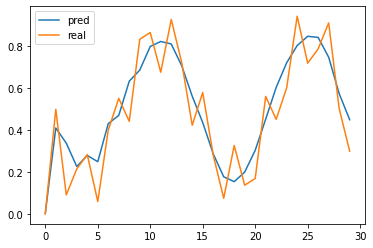

In [ ]:
ax = plt.figure().gca()

ax.plot(seq_pred.cpu().detach().numpy())
ax.plot(test_seq.cpu().detach().numpy())
plt.legend(['pred', 'real'])